In [3]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
50000 train samples
10000 test samples


In [5]:
batch_size = 64  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

In [6]:
# Normalize the data. Before we need to connvert data type to float for computation.
#print(x_train[0])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#print(x_train[0])'

In [7]:
# Convert class vectors to binary class matrices. This is called one hot encoding.
print(y_train[0])
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train[0])

[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [8]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# ADDED THIRD CONV => RELU => POOL LAYER
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 

# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [9]:
# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
history = None  # For recording the history of trainning process.
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Not using data augmentation.
Epoch 1/100
782/782 [==============================] - 299s 381ms/step - loss: 2.0374 - accuracy: 0.2292 - val_loss: 1.8027 - val_accuracy: 0.3419
Epoch 2/100
782/782 [==============================] - 288s 369ms/step - loss: 1.7417 - accuracy: 0.3553 - val_loss: 1.6429 - val_accuracy: 0.4033
Epoch 3/100
782/782 [==============================] - 299s 382ms/step - loss: 1.5757 - accuracy: 0.4207 - val_loss: 1.4800 - val_accuracy: 0.4630
Epoch 4/100
782/782 [==============================] - 296s 378ms/step - loss: 1.4649 - accuracy: 0.4633 - val_loss: 1.4503 - val_accuracy: 0.4754
Epoch 5/100
782/782 [==============================] - 285s 365ms/step - loss: 1.3808 - accuracy: 0.4998 - val_loss: 1.4449 - val_accuracy: 0.4769
Epoch 6/100
782/782 [==============================] - 294s 376ms/step - loss: 1.3061 - accuracy: 0.5271 - val_loss: 1.2077 - val_accuracy: 0.5655
Epoch 7/100
782/782 [==============================] - 294s 376ms/step - loss: 1.2445 - a

In [4]:
history = {}
history['loss'] = [2.0374, 1.7417, 1.5757, 1.4649, 1.3808, 1.3061, 1.2445, 1.1872, 1.1398, 1.0963, 1.0570, 1.0235, 0.9929, 0.9591, 0.9364, 0.9100, 0.8869, 0.8661, 0.8390, 0.8209, 0.8013]
history['accuracy'] = [0.2292, 0.3553, 0.4207, 0.4633, 0.4998, 0.5271, 0.5536, 0.5771, 0.5961, 0.6114, 0.6250, 0.6377, 0.6483, 0.6609, 0.6711, 0.6785, 0.6878, 0.6952, 0.7051, 0.7114, 0.7171]
history['val_loss'] = [1.8027, 1.6429, 1.4800, 1.4503, 1.4449, 1.2077, 1.2611, 1.1671, 1.1235, 1.1274, 0.9837, 1.0006, 1.0143, 0.9255, 1.0295, 0.8674, 0.9036, 0.8238, 0.8441, 0.7869, 0.8083]
history['val_accuracy'] = [0.3419, 0.4033, 0.4630, 0.4754, 0.4769, 0.5655, 0.5505, 0.5739, 0.6054, 0.5958, 0.6485, 0.6443, 0.6454, 0.6722, 0.6344, 0.6924, 0.6887, 0.7163, 0.7059, 0.7245, 0.7107]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


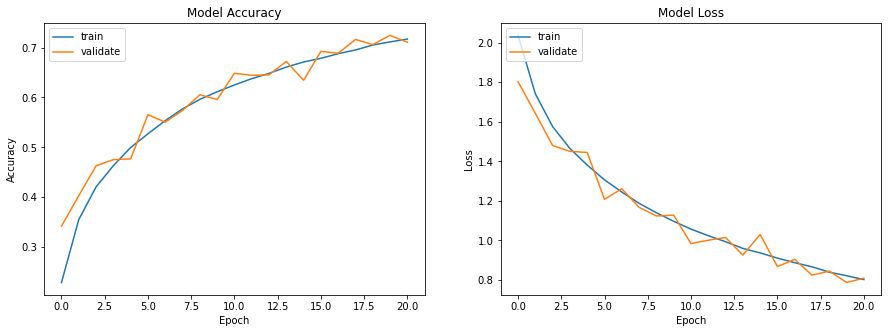

In [6]:
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history['accuracy']) 
    axs[0].plot(history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history['loss']) 
    axs[1].plot(history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.keys())

plotmodelhistory(history)

In [7]:
history = {
    'loss': [2.0374, 1.7417, 1.5757, 1.4649, 1.3808, 1.3061, 1.2445, 1.1872, 1.1398, 1.0963, 1.0570, 1.0235, 0.9929, 0.9591, 0.9364, 0.9100, 0.8869, 0.8661, 0.8390, 0.8209, 0.8057],
    'accuracy': [0.2292, 0.3553, 0.4207, 0.4633, 0.4998, 0.5271, 0.5536, 0.5771, 0.5961, 0.6114, 0.6250, 0.6377, 0.6483, 0.6609, 0.6711, 0.6785, 0.6878, 0.6952, 0.7051, 0.7114, 0.7175],
    'val_loss': [1.8027, 1.6429, 1.4800, 1.4503, 1.4449, 1.2077, 1.2611, 1.1671, 1.1235, 1.1274, 0.9837, 1.0006, 1.0143, 0.9255, 1.0295, 0.8674, 0.9036, 0.8238, 0.8441, 0.7869, 0.7735],
    'val_accuracy': [0.3419, 0.4033, 0.4630, 0.4754, 0.4769, 0.5655, 0.5505, 0.5739, 0.6054, 0.5958, 0.6485, 0.6443, 0.6454, 0.6722, 0.6344, 0.6924, 0.6887, 0.7163, 0.7059, 0.7245, 0.7294]
}


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


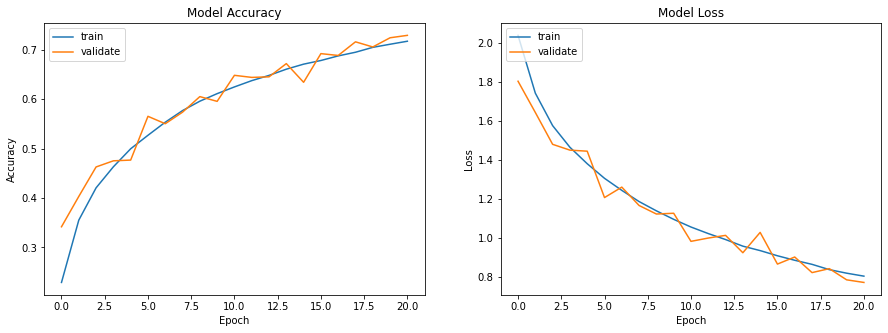

In [8]:
# list all data in history
print(history.keys())

plotmodelhistory(history)

In [9]:
import re

def extract_training_log(log_path):
    with open(log_path, 'r') as f:
        log = f.read()
    epochs = re.findall(r'Epoch (\d+/\d+)', log)
    loss = re.findall(r'loss: ([0-9]+\.[0-9]+)', log)
    accuracy = re.findall(r'accuracy: ([0-9]+\.[0-9]+)', log)
    val_loss = re.findall(r'val_loss: ([0-9]+\.[0-9]+)', log)
    val_accuracy = re.findall(r'val_accuracy: ([0-9]+\.[0-9]+)', log)
    history = {'epochs': epochs,
               'loss': loss,
               'accuracy': accuracy,
               'val_loss': val_loss,
               'val_accuracy': val_accuracy}
    return history

In [10]:
history = extract_training_log('3cnn+512_50Dropout')

dict_keys(['epochs', 'loss', 'accuracy', 'val_loss', 'val_accuracy'])


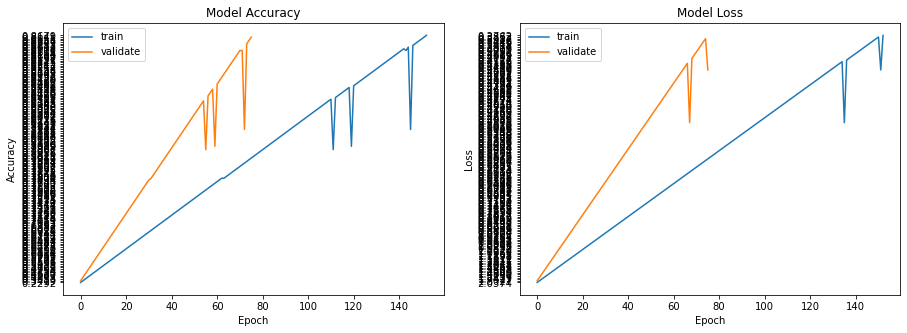

In [11]:
# list all data in history
print(history.keys())

plotmodelhistory(history)